In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py
import os

from tabulate import tabulate


In [3]:

def add_circles(mesh, centers, radii):
    Ny, Nx = mesh.shape
    for center, radius in zip(centers, radii):
        y_center, x_center = center
        for y in range(Ny):
            for x in range(Nx):
                distance = np.sqrt((y - y_center)**2 + (x - x_center)**2)
                if distance <= radius:
                    mesh[y, x] = 0
    return mesh

20.0
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


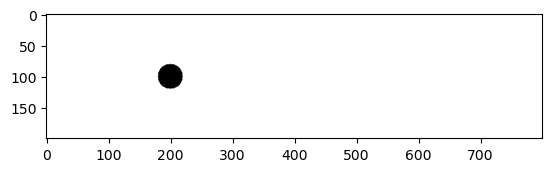

In [4]:
Nx = 800
Ny = 200

mesh = np.ones((Ny, Nx), dtype=np.int64)
# mesh[0, :] = 0
# mesh[Ny-1, :] = 0

centers = [(int(Ny/2), int(Nx/4))]
radii = [Ny/10]
print(radii[0])

mesh = add_circles(mesh, centers, radii)

plt.figure()
plt.imshow(mesh, cmap='grey')

print(mesh)

# mesh_save = mesh.reshape((Nx*Ny, 1))
# np.savetxt('cylinder.dat', mesh_save, fmt='%i')

### uncomment to save h5 file
with h5py.File("binary_media.h5", "w") as hdf5_file:
    hdf5_file.create_dataset("binary_media", data = mesh.transpose())

In [5]:
# Lattice units
u_lb = 0.01
Re = 200
nu_lb = u_lb * radii[0] * 2/Re
tau_lb = 3. * nu_lb + 0.5

# Physical units
C_l = 0.001 # m
nu_phy = 1.46e-5  # m2/s
C_nu = nu_phy / nu_lb # m2/s
C_t = C_l*C_l/C_nu  # s
C_u = C_l / C_t # m/s
u_phy = u_lb * C_u  # m/s
D = radii[0] * C_l * 2

# Confirm reynolds number with physcal parameters
Re_phy_confirm = u_phy * D / nu_phy

# Data to print in a table
data = [
    ["Lattice Velocity (u_lb)", u_lb],
    ["Lattice Reynolds Number (Re)", Re],
    ["Lattice Kinematic Viscosity (nu_lb)", nu_lb],
    ["Relaxation Time (tau_lb)", tau_lb],
    ["Conversion Factor for Kinematic Viscosity (C_nu)", C_nu],
    ["Conversion Factor for Time (C_t)", C_t],
    ["Conversion Factor for Velocity (C_u)", C_u],
    ["Physical Velocity (u_phy)", u_phy],
    ["Physical Diameter (D)", D],
    ["Confirmed Reynolds Number (Re_phy_confirm)", Re_phy_confirm]
]

# Column headers
headers = ["Parameter", "Value"]

# Print the table
print(tabulate(data, headers=headers, tablefmt="pretty"))


+--------------------------------------------------+----------------------+
|                    Parameter                     |        Value         |
+--------------------------------------------------+----------------------+
|             Lattice Velocity (u_lb)              |         0.01         |
|           Lattice Reynolds Number (Re)           |         200          |
|       Lattice Kinematic Viscosity (nu_lb)        |        0.002         |
|             Relaxation Time (tau_lb)             |        0.506         |
| Conversion Factor for Kinematic Viscosity (C_nu) |        0.0073        |
|         Conversion Factor for Time (C_t)         | 0.000136986301369863 |
|       Conversion Factor for Velocity (C_u)       |  7.300000000000001   |
|            Physical Velocity (u_phy)             | 0.07300000000000001  |
|              Physical Diameter (D)               |         0.04         |
|    Confirmed Reynolds Number (Re_phy_confirm)    |        200.0         |
+-----------

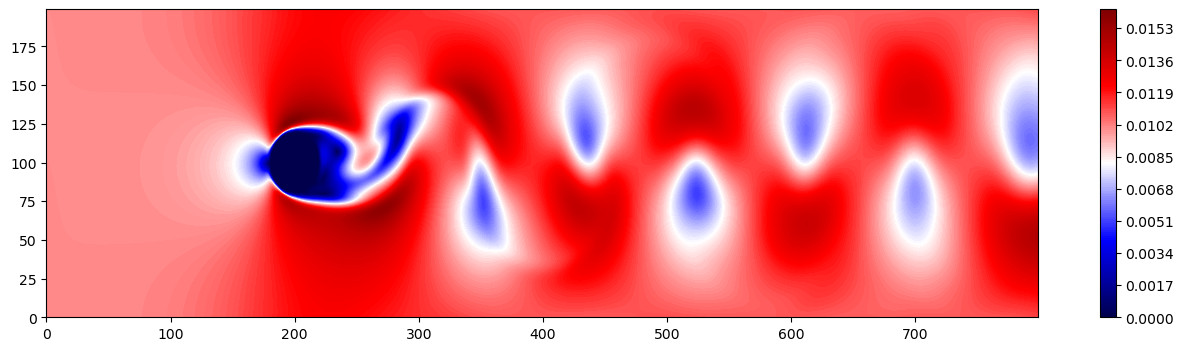

In [6]:
with h5py.File('cylinder.h5', 'r') as hf:
    keys = list(hf.keys())
    c_key_idx = np.sort([int(k.split('.')[-1]) for k in keys if 'speed' in k])

    plot_var = hf['speed.'+str(c_key_idx[-1])][()]
    plt.figure(figsize=(16, 4))
    plt.contourf(plot_var, cmap='seismic', levels=200)
    plt.colorbar()

In [ ]:
folder_path = "./speed"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

plot_var_name = 'speed'
every_n_frames = 6
with h5py.File('cylinder.h5', 'r') as hf:
    keys = list(hf.keys())
    c_key_idx = np.sort([int(k.split('.')[-1]) for k in keys if plot_var_name in k])
    # psi = hf['speed.0'][()].T

    for i in range(2502, 4000):
        if i % every_n_frames == 0:
            t = c_key_idx[i]
            plot_var = hf[f'{plot_var_name}.{str(t)}'][()]

            # remove all values where psi == 0
            # plot_var *= psi > 0.0

            figsize=(16, 4)
            ax = plt.gca()
            im = plt.imshow(plot_var, cmap='seismic', vmin=0, vmax=0.016)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            cbar.set_label('Magnitude of velocity')
            plt.tight_layout()
            plt.savefig(folder_path + f'/{plot_var_name}_{t:04d}.png', dpi=500, bbox_inches='tight')
            plt.close()


In [ ]:
folder_path = "./vorticity"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")

every_n_frames = 6

plot_var_name='vorticity'
with h5py.File('cylinder.h5', 'r') as hf:
  keys = list(hf.keys())
  c_key_idx = np.sort([int(k.split('.')[-1]) for k in keys if 'u_x' in k])
  # psi = hf['speed.0'][()].T

  for i in range(0, 4000):
      if i % every_n_frames == 0:
          t = c_key_idx[i]

          u_0 = hf[f'u_x.{t}'][()]
          u_1 = hf[f'u_y.{t}'][()]

          du1_dx = np.gradient(u_1, axis=1)
          du0_dy = np.gradient(u_0, axis=0)
          vorticity = du1_dx - du0_dy

          figsize=(16, 4)
          ax = plt.gca()
          vorticity = du1_dx - du0_dy
          im = plt.imshow(vorticity, cmap="seismic", vmin=-0.005, vmax=0.005)
          divider = make_axes_locatable(ax)
          cax = divider.append_axes("right", size="5%", pad=0.05)
          cbar = plt.colorbar(im, cax=cax)
          cbar.set_label('Vorticity')
          plt.tight_layout()
          plt.savefig(folder_path + f'/{plot_var_name}_{t:04d}.png', dpi=500, bbox_inches='tight')
          plt.close()


In [ ]:
import os
from moviepy.editor import ImageSequenceClip

folder_path = "./speed"
output_video = "speed.mp4"
frame_rate = 60
print(sorted(os.listdir(folder_path)))

image_files = [os.path.join(folder_path, f) for f in sorted(os.listdir(folder_path)) if f.endswith('.png')]

clip = ImageSequenceClip(image_files, fps=frame_rate)

clip.write_videofile(output_video, codec="libx264")

# //////
folder_path = "./vorticity"
output_video = "vorticity.mp4"
frame_rate = 60
print(sorted(os.listdir(folder_path)))

image_files = [os.path.join(folder_path, f) for f in sorted(os.listdir(folder_path)) if f.endswith('.png')]

clip = ImageSequenceClip(image_files, fps=frame_rate)

clip.write_videofile(output_video, codec="libx264")
